In [1]:
%config StoreMagics.autorestore = True
%reset -f
%store -z
%store -r
%whos

Interactive namespace is empty.


## This code has been translated from matlab to perform model reduction of a flexible Beam

In [2]:
import numpy
import sympy
import scipy
import control
import matplotlib.pyplot as plt

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 } )
%matplotlib inline

In [3]:
# Set parameters

# Fixed-fixed or pinned-pinned
fix = 1

# Number of elements
# N = 3*3
N = 3*50

# Geometry
Li = [0.3, 0.65, 0.9, 1.3]
L = max(Li)
h = 0.3/0.5 * 0.5 * 0.01
w = 0.1/0.09 * 0.09
A = w * h
I = 1/12 * w * h**3

# Material properties
rho = 7746
E = 2.0e11

# Modal damping
zeta = 0.02

In [4]:
# Create FEM

# These are the element matrices (Nodes and x coordinate)
Ni = numpy.round(numpy.diff([0] + Li) * N / L)
li = numpy.diff([0] + Li) / Ni

# These are the coordinates for a single element
le = []
for i in range(4):
    le = numpy.concatenate( ( le, li[i] * numpy.ones( int(Ni[i]) ) ) )
xe = numpy.cumsum(numpy.concatenate(([0],le)))

# Check element model in book to validate sizes of matrices
M = numpy.zeros((2*N + 2, 2*N + 2))
K = numpy.zeros((2*N + 2, 2*N + 2))

# Check model form in book
for i in range(0,N):
    Me = rho * w * h * le[i] / 420 * numpy.array(
        [
            [156, 22 * le[i], 54, -13 * le[i]],
            [22 * le[i], 4 * le[i] ** 2, 13 * le[i], -3 * le[i] ** 2],
            [54, 13 * le[i], 156, -22 * le[i]],
            [-13 * le[i], -3 * le[i] ** 2, -22 * le[i], 4 * le[i] ** 2],
        ]
    )

    Ke = E * I / le[i] ** 3 * numpy.array(
        [
            [12, 6 * le[i], -12, 6 * le[i]],
            [6 * le[i], 4 * le[i] ** 2, -6 * le[i], 2 * le[i] ** 2],
            [-12, -6 * le[i], 12, -6 * le[i]],
            [6 * le[i], 2 * le[i] ** 2, -6 * le[i], 4 * le[i] ** 2],
        ]
    )

    ii = numpy.arange(i*2, (i*2)+4)
    M[numpy.ix_(ii, ii)] += Me
    K[numpy.ix_(ii, ii)] += Ke
    
# Input and output matrices
bw = numpy.zeros((2*N+2, 1))
bu = numpy.zeros((2*N+2, 1))
cv = numpy.zeros((1, 2*N+2))
cy = numpy.zeros((1, 2*N+2))
bw[2*int(numpy.sum(Ni[0:2])),0] = 1
bu[2*int(numpy.sum(Ni[0:3])),0] = 1
cv[0, 2*int(numpy.sum(Ni[0:2]))] = 1
cy[0, 2*int(Ni[0])] = 1

# Select fixed or pinned ends
if fix:
    iif = [0, 1, 2*N, 2*N+1] # fixed-fixed
else:
    iif = [0, 2*N] # pinned-pinned

ii = numpy.setdiff1d(numpy.arange(0, 2*N+1), iif)
iiu = numpy.where(numpy.mod(ii, 2) == 0)[0]
iit = numpy.where(numpy.mod(ii, 2) == 1)[0]

M = M[ii[:,None], ii]
K = K[ii[:,None], ii]
bw = bw[ii,:]
bu = bu[ii,:]
cy = cy[:,ii]
cv = cv[:,ii]
ndof = M.shape[0]

Damped Modes:  [ 9.272 25.558 50.105 82.826]
Modes:  [ 9.272+0.j 25.558+0.j 50.105+0.j 82.826+0.j]


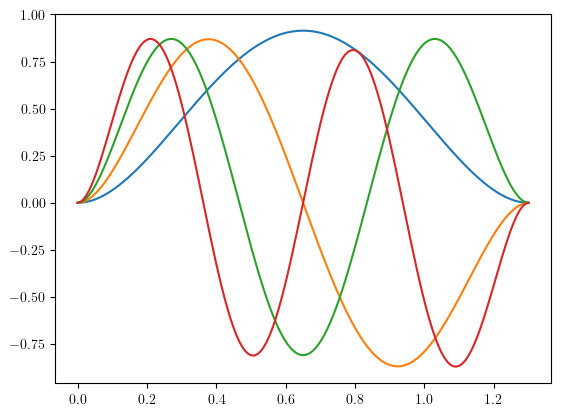

In [5]:
# Plot Modes, normalize and re-accommodate coordinates

# Model modes of vibration without damping (Assuming D=0)
# V are eigenvectors (vibration mode) and Omega2 are eigenvalues (natural frequencies square)

# Calculate undamped modes K@V = M@V@numpy.diag(omega2)
omega2, V = scipy.linalg.eig(K, M)
ii = numpy.argsort(omega2)
omega2 = omega2[ii]
V = V[:, ii]
omega = numpy.sqrt(omega2)
f = omega / (2 * numpy.pi)

# Forcing eigenvectors (vibrations modes) to start > 0 
iivneg = numpy.where(V[0,:]<0)[0]
V[:,iivneg] = -V[:,iivneg]

# M-normalize such that V'MV = I
for i in range(ndof):
    V[:, i] /= numpy.sqrt((V[:, i].T) @ M @ V[:, i])
Vinv = numpy.linalg.inv(V)

# Damping matrix D
D = Vinv.T @ numpy.diag(2*zeta*omega) @ Vinv

# Damped eigenfrequencies
omegad = omega * numpy.sqrt(1 - zeta**2)

# Select fixed or pinned ends
if fix:
    fa = numpy.array([4.7300, 7.8532, 10.9956, 14.1372])**2 / (2 * numpy.pi * L**2) * numpy.sqrt(E*I/(rho*A)) # fixed-fixed
else:
    fa = (numpy.arange(1, 5)*numpy.pi)**2 / (2 * numpy.pi * L**2) * numpy.sqrt(E*I/(rho*A)) # pinned-pinned

# Plot undamped modes
print("Damped Modes: ", fa)
print("Modes: ", f[:4])
for i in range(4):
    y = numpy.concatenate(([0], V[iiu, i], [0]))
    plt.plot(xe, y)
plt.show()

# Find boundary coordinates
iib = numpy.concatenate((numpy.where(bw == 1)[0], numpy.where(bu == 1)[0]))
iii = numpy.setdiff1d(range(0,ndof),iib)
iio = numpy.concatenate((iib, iii))

# Re-order coordinates to have input in the first to elements
T = numpy.zeros((ndof,ndof))
for i in range(0,ndof):
    T[i,iio[i]] = 1
M  = T @ M @ T.T
D  = T @ D @ T.T
K  = T @ K @ T.T
bw = T @ bw
bu = T @ bu
cv = cv @ T.T
cy = cy @ T.T
iib = numpy.arange(0,2)
iii = numpy.arange(2,ndof)

In [6]:
# Create FOM Plant Matrices Ap Bu Bw Cy

# Number of states
full_order = 2*ndof

# Create state-space model
invM = numpy.linalg.inv(M)
Ap  = numpy.row_stack([
        numpy.column_stack([numpy.zeros((ndof,ndof)), numpy.eye(ndof,ndof)]),
        numpy.column_stack([-1.0*invM @ K, -invM @ D])
        ])

# Controller input-output matrices
Bw = numpy.row_stack([numpy.zeros((ndof,1)), invM @ bw])
Cv = numpy.column_stack([cv, numpy.zeros((1,ndof))])

# Performance input-output matrices
Bu = numpy.row_stack([numpy.zeros((ndof,1)), invM @ bu])
Cy = numpy.column_stack([cy, numpy.zeros((1,ndof))])

# Plant initial state
xp0 = numpy.zeros((full_order,1))

# Construct system and its transferfuction
# mathcalP = control.ss(Ap, numpy.column_stack([Bw,Bu]), numpy.row_stack([Cv,Cy]), numpy.zeros((2,2)))
# tfmathcalP = control.ss2tf(mathcalP)
# display(Math('\\mathcal{P} = '), tfmathcalP)

In [7]:
# Model reduction using Craig-Bampton method
# k = 28 #18; #4;
k = 38
ndofr = 2 + k

Mii = M[numpy.ix_(iii,iii)] # M[iii[:,None],iii]
Kii = K[numpy.ix_(iii,iii)] # K[iii[:,None],iii]
Kib = K[numpy.ix_(iii,iib)] # K[iii[:,None],iib]

omegaii2, Vii = scipy.linalg.eig(Kii,Mii)
ii = numpy.argsort(omegaii2)
omegaii2 = numpy.diag(omegaii2[ii])
Vii = Vii[:,ii]
omegaii = numpy.sqrt(omegaii2)
fii = omegaii/(2*numpy.pi)

T_craig_bampton = numpy.row_stack([
        numpy.column_stack([numpy.eye(2,2), numpy.zeros((2,k))]),
        numpy.column_stack([-1*numpy.linalg.inv(Kii) @ Kib , Vii[:, numpy.arange(0,k)]])
    ])

M_cb  = T_craig_bampton.T @ M @ T_craig_bampton
D_cb  = T_craig_bampton.T @ D @ T_craig_bampton
K_cb  = T_craig_bampton.T @ K @ T_craig_bampton
bw_cb = T_craig_bampton.T @ bw
bu_cb = T_craig_bampton.T @ bu
cv_cb = cv @ T_craig_bampton
cy_cb = cy @ T_craig_bampton

In [8]:
# Create Craig-Bampton FOM Plant Matrices Ap Bu Bw Cy

# Number of states
reduced_order = 2*ndofr

# Create state-space model
invM_cb = numpy.linalg.inv(M_cb)
Ap_cb  = numpy.row_stack([
        numpy.column_stack([numpy.zeros((ndofr,ndofr)), numpy.eye(ndofr,ndofr)]),
        numpy.column_stack([-1.0*invM_cb @ K_cb, -invM_cb @ D_cb])
        ])

# Controller input-output matrices
Bw_cb = numpy.row_stack([numpy.zeros((ndofr,1)), invM_cb @ bw_cb])
Cv_cb = numpy.column_stack([cv_cb, numpy.zeros((1,ndofr))])

# Performance input-output matrices
Bu_cb = numpy.row_stack([numpy.zeros((ndofr,1)), invM_cb @ bu_cb])
Cy_cb = numpy.column_stack([cy_cb, numpy.zeros((1,ndofr))])

# Plant initial state
xp0_cb = numpy.zeros((reduced_order,1))

# Construct system and its transfer fuction
mathcalP_cb = control.ss(Ap_cb, 
                              numpy.column_stack([Bw_cb,Bu_cb]), 
                              numpy.row_stack([Cv_cb,Cy_cb]), 
                              numpy.zeros((2,2)))
tfMathcalP_cb = control.ss2tf(mathcalP_cb)
normInfMathcalP_cb = numpy.array([numpy.linalg.svd(mathcalP_cb(1.0j*w), compute_uv=False) for w in numpy.logspace(1,5,1500)]).max()

display(Math('\\mathcal{P}_{Craig-Bampton} = '), tfMathcalP_cb)
display(Math('\\lVert \\mathcal{P}_{Craig-Bampton} \\rVert_{\\infty} = ' + str(normInfMathcalP_cb)))

c:\Users\20224091\Anaconda3\envs\control_env\lib\site-packages\control\statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


<IPython.core.display.Math object>

TransferFunction([[array([1.649e+001, 3.792e+005, 2.520e+011, 5.425e+015, 1.790e+021,
       3.604e+025, 7.858e+030, 1.479e+035, 2.393e+040, 4.204e+044,
       5.378e+049, 8.810e+053, 9.264e+058, 1.413e+063, 1.254e+068,
       1.778e+072, 1.358e+077, 1.786e+081, 1.191e+086, 1.450e+090,
       8.525e+094, 9.592e+098, 5.016e+103, 5.201e+107, 2.435e+112,
       2.320e+116, 9.773e+120, 8.534e+124, 3.248e+129, 2.590e+133,
       8.934e+137, 6.483e+141, 2.032e+146, 1.336e+150, 3.810e+154,
       2.261e+158, 5.876e+162, 3.131e+166, 7.417e+170, 3.529e+174,
       7.626e+178, 3.221e+182, 6.346e+186, 2.363e+190, 4.243e+194,
       1.383e+198, 2.259e+202, 6.388e+205, 9.486e+209, 2.305e+213,
       3.105e+217, 6.416e+220, 7.817e+224, 1.356e+228, 1.490e+232,
       2.140e+235, 2.113e+239, 2.471e+242, 2.181e+246, 2.036e+249,
       1.598e+253, 1.164e+256, 8.066e+259, 4.459e+262, 2.705e+266,
       1.096e+269, 5.759e+272, 1.638e+275, 7.354e+278, 1.389e+281,
       5.236e+284, 6.074e+286, 1.874e+290, 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

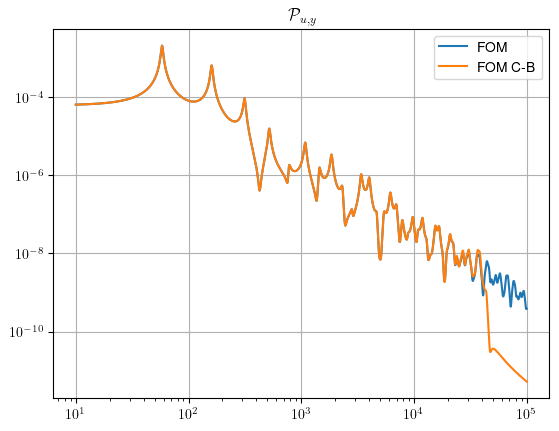

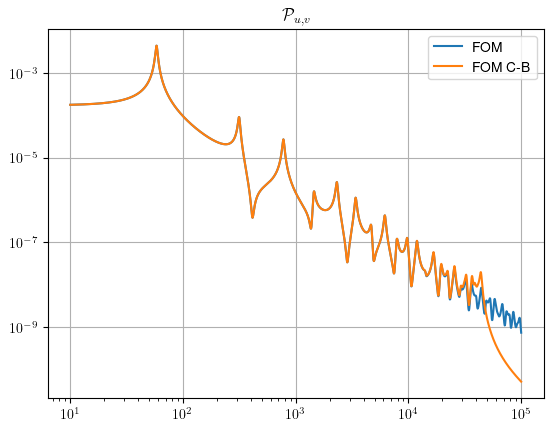

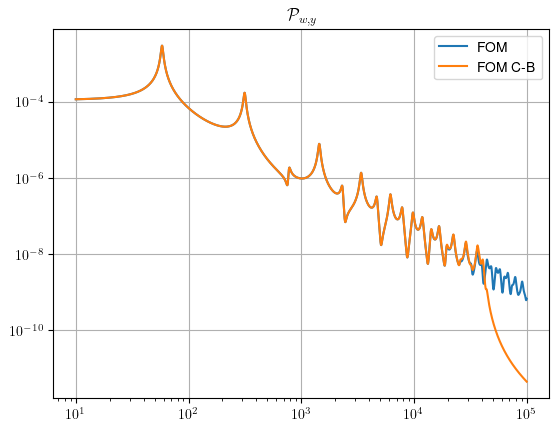

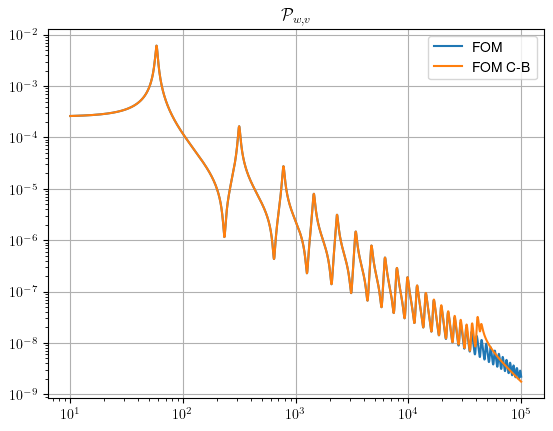

In [9]:
# Compare FOM and Craig-Bampton FOM transfer functions

freq = numpy.logspace(1,5,2000) # rads/sec

Puy = numpy.zeros(freq.shape, dtype='complex128')
Puv = numpy.zeros(freq.shape, dtype='complex128')
Pwy = numpy.zeros(freq.shape, dtype='complex128')
Pwv = numpy.zeros(freq.shape, dtype='complex128')
PP = numpy.zeros((2,2,len(freq)), dtype='complex128')
PPSingVals = numpy.zeros((2,1,len(freq)))

Puy_cb = numpy.zeros(freq.shape, dtype='complex128')
Puv_cb = numpy.zeros(freq.shape, dtype='complex128')
Pwy_cb = numpy.zeros(freq.shape, dtype='complex128')
Pwv_cb = numpy.zeros(freq.shape, dtype='complex128')
PP_cb = numpy.zeros((2,2,len(freq)), dtype='complex128')
PPSingVals_cb = numpy.zeros((2,1,len(freq)))

for i in range(0,len(freq)):
    s = 1.0j*freq[i]
    
    invsImA = numpy.linalg.inv(s**2*M  + s*D  + K)
    Puy[i] = (cy @ invsImA  @ bu).reshape((1,))
    Puv[i] = (cv @ invsImA  @ bu).reshape((1,))
    Pwy[i] = (cy @ invsImA  @ bw).reshape((1,))
    Pwv[i] = (cv @ invsImA  @ bw).reshape((1,))
    PP[:,:,i] = numpy.vstack([numpy.array([Pwv[i],Puv[i]]),numpy.array([Pwy[i],Puy[i]])])
    PPSingVals[:,0,i] = numpy.linalg.svd(PP[:,:,i],compute_uv=False)
    
    invsImA_cb = numpy.linalg.inv(s**2*M_cb  + s*D_cb  + K_cb)
    Puy_cb[i] = (cy_cb @ invsImA_cb @ bu_cb).reshape((1,))
    Puv_cb[i] = (cv_cb @ invsImA_cb @ bu_cb).reshape((1,))
    Pwy_cb[i] = (cy_cb @ invsImA_cb @ bw_cb).reshape((1,))
    Pwv_cb[i] = (cv_cb @ invsImA_cb @ bw_cb).reshape((1,))
    PP_cb[:,:,i] = numpy.vstack([numpy.array([Pwv_cb[i],Puv_cb[i]]),numpy.array([Pwy_cb[i],Puy_cb[i]])])
    PPSingVals_cb[:,0,i] = numpy.linalg.svd(PP_cb[:,:,i], compute_uv=False)

# Norms
display(Math('\\lVert \\mathcal{P} \\rVert_{\\infty} = ' + str(PPSingVals.max())))
display(Math('\\lVert \\mathcal{P}_{Craig-Bampton} \\rVert_{\\infty} = ' + str(PPSingVals_cb.max())))

# Constructed bode plots
plt.loglog(freq, numpy.abs(Puy), label='FOM')
plt.loglog(freq, numpy.abs(Puy_cb), label='FOM C-B')
plt.title( '$\\mathcal{P}_{u,y}$' )
plt.legend()
plt.grid()
plt.show()

plt.loglog(freq, numpy.abs(Puv), label='FOM')
plt.loglog(freq, numpy.abs(Puv_cb), label='FOM C-B')
plt.title( '$\\mathcal{P}_{u,v}$' )
plt.legend()
plt.grid()
plt.show()

plt.loglog(freq, numpy.abs(Pwy), label='FOM')
plt.loglog(freq, numpy.abs(Pwy_cb), label='FOM C-B')
plt.title( '$\\mathcal{P}_{w,y}$' )
plt.legend()
plt.grid()
plt.show()

plt.loglog(freq, numpy.abs(Pwv), label='FOM')
plt.loglog(freq, numpy.abs(Pwv_cb), label='FOM C-B')
plt.title( '$\\mathcal{P}_{w,v}$' )
plt.legend()
plt.grid()
plt.show()

# Plots using control module
# control.bode_plot(tf_mathcalP_cbmodel[0,0], freq)
# plt.title( '$\\mathcal{P}_{cb,w,v}$', y=2.25 )
# plt.show()

# plt.figure()
# control.bode_plot(tf_mathcalP_cbmodel[1,0], freq)
# plt.title( '$\\mathcal{P}_{cb,w,y}$', y=2.25 )
# plt.show()

# plt.figure()
# control.bode_plot(tf_mathcalP_cbmodel[0,1], freq)
# plt.title( '$\\mathcal{P}_{cb,u,v}$', y=2.25 )
# plt.show()

# plt.figure()
# control.bode_plot(tf_mathcalP_cbmodel[1,1], freq)
# plt.title( '$\\mathcal{P}_{cb,u,y}$', y=2.25 )
# plt.show()

In [10]:
# Defining output-extended plant model

# Get plant
mathcalP = mathcalP_cb
# mathcalP = control.rss(100,2,2)
normInfMathcalP, normInfMathcalP_MIMO = ControlUtils.hinfnorm(mathcalP)
display(Math('\\lVert \\mathcal{P} \\rVert_{\\infty} = ' + str(normInfMathcalP)))

# Creating extended plant with [v,dv,y]^T as output
Ap = mathcalP.A
Bw = mathcalP.B[:,0:1]
Bu = mathcalP.B[:,1:2]
Cv = mathcalP.C[0:1,:]
Cy = mathcalP.C[1:2,:]
mathcalPext = control.ss(Ap,
                         numpy.column_stack([Bw, Bu]), 
                         numpy.row_stack([Cv, Cv@Ap, Cy]),
                         numpy.row_stack([
                             numpy.zeros( (Cv.shape[0],2) ),
                             numpy.column_stack([ Cv@Bw, Cv@Bu ]),
                             numpy.zeros( (Cy.shape[0],2) )
                         ])
                        )
normInfMathcalPext, normInfMathcalPext_MIMO = ControlUtils.hinfnorm(mathcalPext)
display(Math('\\lVert \\mathcal{P}_{ext} \\rVert_{\\infty} = ' + str(normInfMathcalPext)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
%store -d mathcalP normInfMathcalP normInfMathcalP_MIMO mathcalPext normInfMathcalPext normInfMathcalPext_MIMO
%store mathcalP normInfMathcalP normInfMathcalP_MIMO mathcalPext normInfMathcalPext normInfMathcalPext_MIMO

Stored 'mathcalP' (LinearIOSystem)
Stored 'normInfMathcalP' (float64)
Stored 'normInfMathcalP_MIMO' (ndarray)
Stored 'mathcalPext' (LinearIOSystem)
Stored 'normInfMathcalPext' (float64)
Stored 'normInfMathcalPext_MIMO' (ndarray)
